In [4]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report

In [5]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [7]:
try:
    import tensorflow as tf
    from tensorflow import keras
    TF_AVAILABLE=True
except Exception:
    TF_AVAILABLE=False

RANDOM_STATE=42

In [8]:
ds=pd.read_csv('earthquakes.csv')
print("Loaded dataset shape:",ds.shape)
print("Columns:",ds.columns.tolist())

Loaded dataset shape: (8394, 18)
Columns: ['id', 'impact.gap', 'impact.magnitude', 'impact.significance', 'location.depth', 'location.distance', 'location.full', 'location.latitude', 'location.longitude', 'location.name', 'time.day', 'time.epoch', 'time.full', 'time.hour', 'time.minute', 'time.month', 'time.second', 'time.year']


In [9]:
def detect_magnitude_column(ds):
    candidates=[c for c in ds.columns if c.lower() in ('mag','magnitude','ml','impact.magnitude','magnitude_value','mag_value')]
    if candidates:
        return candidates[0]
    candidates=[c for c in ds.columns if 'mag' in c.lower()]
    if candidates:
         return candidates[0]

In [10]:
def detect_magnitude_column(ds):
    numeric_cols = ds.select_dtypes(include=[np.number]).columns.tolist()
    
    for c in numeric_cols:
        vals = ds[c].dropna()
        if vals.empty:
            continue
        frac = vals.between(0, 10).mean()
        if frac > 0.8:  # NOTE: 8 should be 0.8 (i.e., 80%)
            return c
    
    raise ValueError("Could not detect magnitude column automatically. Name columns appropriately.")

# Example usage
mag_col = detect_magnitude_column(ds)
print("Using magnitude column:", mag_col)


Using magnitude column: impact.magnitude


In [11]:
ds=ds.dropna(subset=[mag_col]).reset_index(drop=True)
ds[mag_col]=pd.to_numeric(ds[mag_col],errors='coerce')
ds=ds.dropna(subset=[mag_col]).reset_index(drop=True)

In [12]:
drop_candidates=[c for c in ds.columns if c.lower() in ('id','time','timestamp','place','description','eventid')]
X=ds.drop(columns=[mag_col]+[c for c in drop_candidates if c in ds.columns], errors='ignore')
y=ds[mag_col].astype(float)

In [13]:
num_cols=X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols=X.select_dtypes(include=['object','category']).columns.tolist()

In [14]:
if len(num_cols)+len(cat_cols)==0:
    lat=next((c for c in ds.columns if 'lat' in c.lower()), None)
    lon=next((c for c in ds.columns if 'lon' in c.lower() or 'long' in c.lower()), None)
    if lat and lon:
        X=ds[[lat, lon]].copy()
        num_cols=X.columns.tolist()
        cat_cols=[]
    else:
        raise ValueError("No usable features detected. Provide at least one numberic/location features besides magnitude.")

In [15]:
TOP_CAT=10
def limit_top_categories(series, top_n=TOP_CAT):
    top=series.value_counts().nlargest(top_n).index
    return series.where(series.isin(top),other='_other_')

for c in cat_cols:
    X[c]=X[c].fillna('missing').astype(str)
    X[c]=limit_top_categories(X[c],top_n=TOP_CAT)

In [16]:
if len(cat_cols)>3:
    cat_cols=cat_cols[:3]
    X=X[num_cols+cat_cols]

In [17]:
for c in num_cols:
    X[c]=X[c].fillna(X[c].median())

print("Numeric features:",num_cols)
print("Categorical features:",cat_cols)

Numeric features: ['impact.gap', 'impact.significance', 'location.depth', 'location.distance', 'location.latitude', 'location.longitude', 'time.day', 'time.epoch', 'time.hour', 'time.minute', 'time.month', 'time.second', 'time.year']
Categorical features: ['location.full', 'location.name', 'time.full']


In [18]:
numeric_transformer=Pipeline([('scaler',StandardScaler())])
categorical_transformer=Pipeline([('onehot',OneHotEncoder(handle_unknown='ignore',sparse_output=False))])
preprocessor=ColumnTransformer(
    transformers=[
        ('num',numeric_transformer,num_cols),
        ('cat',categorical_transformer,cat_cols)
    ],
    remainder='drop'
)

In [19]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=RANDOM_STATE)
X_train_p=preprocessor.fit_transform(X_train)
X_test_p=preprocessor.transform(X_test)
print("Preprocessed feature shape(train):",X_train_p.shape)

Preprocessed feature shape(train): (6715, 46)


In [20]:
regressors={
    'LinearRegression':LinearRegression(),
    'Ridge':Ridge(random_state=RANDOM_STATE),
    'Lasso':Lasso(random_state=RANDOM_STATE),
    'SVR':SVR(),
    'KNeighbors':KNeighborsRegressor(),
    'RandomForest':RandomForestRegressor(n_estimators=100,random_state=RANDOM_STATE,n_jobs=-1),
    'ExtraTrees':ExtraTreesRegressor(n_estimators=100,random_state=RANDOM_STATE,n_jobs=-1),
    'GradientBoosting':GradientBoostingRegressor(random_state=RANDOM_STATE),
    'MLPRegressor':MLPRegressor(max_iter=300,random_state=RANDOM_STATE)
}

In [21]:
if TF_AVAILABLE:
    print("TensorFlow available;will include a small TF DNN regresssor at the end .")
else:
    print("tensorFlow not available:Skipping TF DNN.")

reg_results=[]
reg_preds={}

for name,model in regressors.items():
    print(f"Training regressor: {name}...",end='')
    try:
        model.fit(X_train_p, y_train)
        preds=model.predict(X_test_p)
        mse=mean_squared_error(y_test,preds)
        rmse=np.sqrt(mse)
        mae=mean_absolute_error(y_test,preds)
        r2=r2_score(y_test,preds)
        reg_results.append({'model':name,'mse':mse,'rmse':rmse,'mae':mae,'r2':r2})
        reg_preds[name]=preds
        print(f"done.R2={r2:.4f},RMSE={rmse:.4f}")
    except Exception as e:
        print("failed:",str(e))
        

TensorFlow available;will include a small TF DNN regresssor at the end .
Training regressor: LinearRegression...done.R2=0.9047,RMSE=0.3548
Training regressor: Ridge...done.R2=0.9046,RMSE=0.3551
Training regressor: Lasso...done.R2=0.0680,RMSE=1.1097
done.R2=0.9849,RMSE=0.1411
done.R2=0.8502,RMSE=0.4449bors...
done.R2=0.9974,RMSE=0.0588Forest...
done.R2=0.9988,RMSE=0.0399rees...
done.R2=0.9981,RMSE=0.0502ntBoosting...
done.R2=0.9952,RMSE=0.0794ressor...


In [22]:
if TF_AVAILABLE:
    try:
        input_dim=X_train_p.shape[1]
        dnn=keras.Sequential([keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(128,activation='relu'),
        keras.layers.Dense(64,activation='relu'),
        keras.layers.Dense(1) 
        ])
        dnn.compile(optimizer='adam',loss='mse')
        dnn.fit(X_train_p,y_train,validation_split=0.1,epochs=40,batch_size=32,verbose=0)
        preds=dnn.predict(X_test_p).flatten()
        mse=mean_squared_error(y_test,preds)
        rmse=np.sqrt(mse)
        mae=mean_absolute_error(y_test,preds)
        r2=r2_score(y_test,preds)
        reg_results.append({'model': 'TF_DNN', 'mse':mse,'rmse':rmse,'mae':mae,'r2':r2})
        reg_preds['TF_DNN']=preds
        print(f"TF_DNN done.R2={r2:.4f},RMSE={rmse:.4f}")
    except Exception as e:
        print("TF DNN failed:",e)

reg_ds=pd.DataFrame(reg_results).sort_values('r2',ascending=False).reset_index(drop=True)
print("\nRegression leaderboard (sorted by R2):")
print(reg_ds[['model','mse','rmse','mae','r2']].to_string(index=False))

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   
TF_DNN done.R2=0.9968,RMSE=0.0647

Regression leaderboard (sorted by R2):
           model      mse     rmse      mae       r2
      ExtraTrees 0.001588 0.039852 0.010476 0.998798
GradientBoosting 0.002519 0.050192 0.013450 0.998093
    RandomForest 0.003458 0.058807 0.010529 0.997383
          TF_DNN 0.004183 0.064677 0.040086 0.996834
    MLPRegressor 0.006311 0.079442 0.049079 0.995223
             SVR 0.019922 0.141146 0.102142 0.984922
LinearRegression 0.125918 0.354849 0.282386 0.904698
           Ridge 0.126064 0.355055 0.282516 0.904587
      KNeighbors 0.197954 0.444920 0.349713 0.850177
           Lasso 1.231442 1.109703 0.801593 0.067972


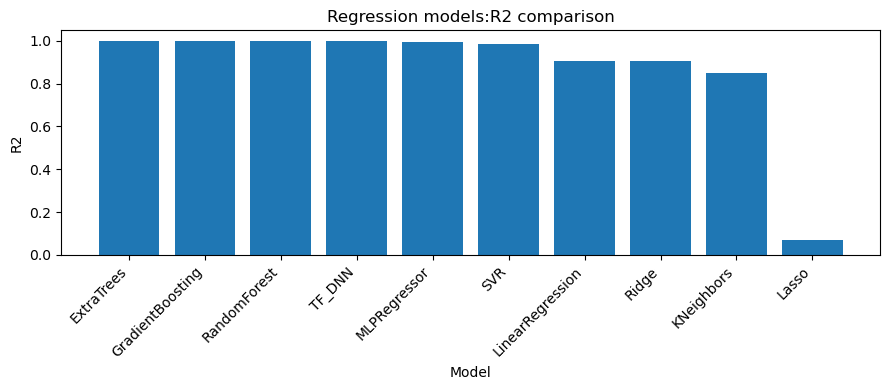

In [23]:
plt.figure(figsize=(9,4))
plt.bar(reg_ds['model'],reg_ds['r2'])
plt.title('Regression models:R2 comparison')
plt.xlabel('Model'); plt.ylabel('R2')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

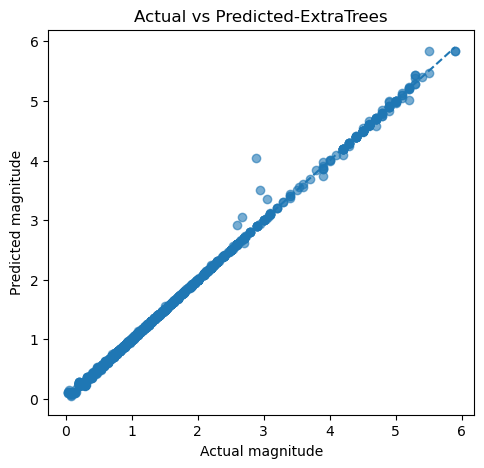

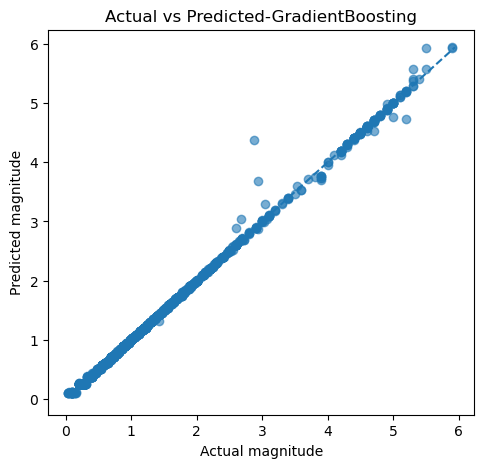

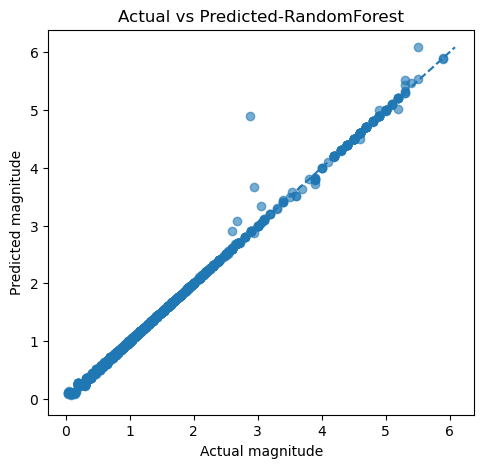

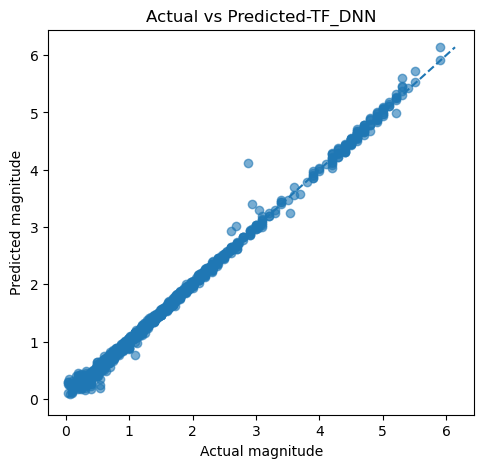

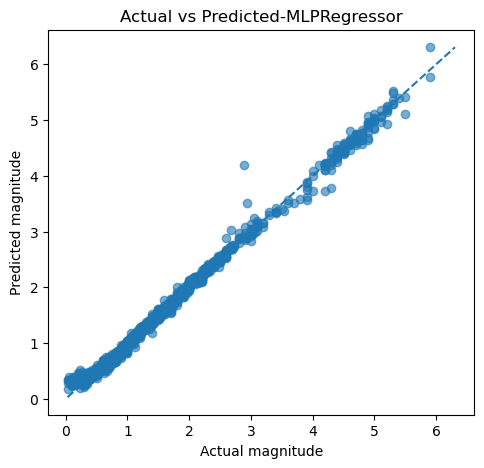

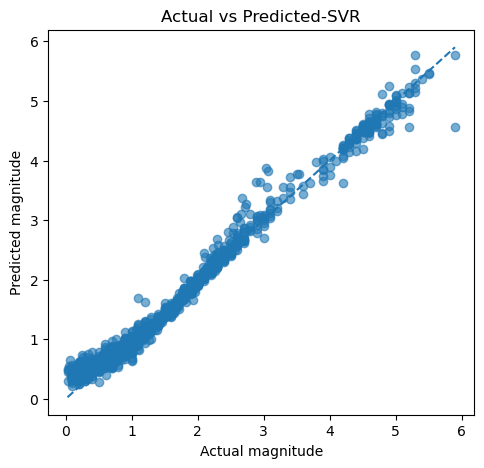

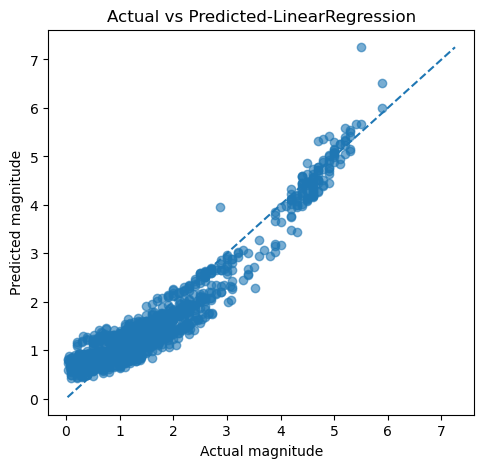

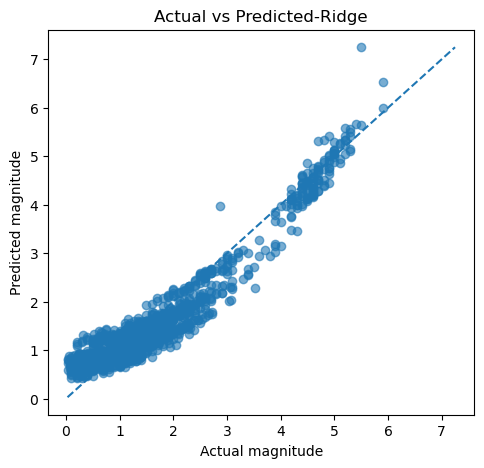

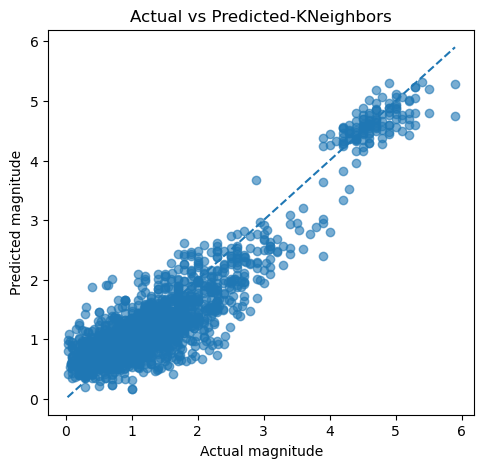

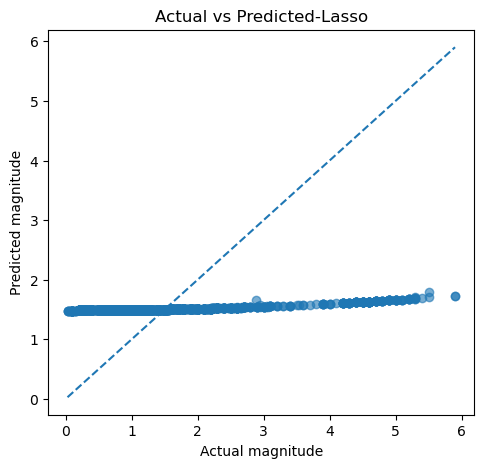

In [24]:
top_regs=reg_ds['model']
for name in top_regs:
    preds=reg_preds.get(name)
    if preds is None:
        continue
    plt.figure(figsize=(5.5,5))
    plt.scatter(y_test,preds,alpha=0.6)
    mn,mx=min(y_test.min(),preds.min()),max(y_test.max(),preds.max())
    plt.plot([mn,mx],[mn,mx],linestyle='--')
    plt.title(f'Actual vs Predicted-{name}')
    plt.xlabel('Actual magnitude');
    plt.ylabel('Predicted magnitude')
    plt.tight_layout
    plt.show()

In [25]:
bins=[-1,4.0,6.0,100]
labels=[0,1,2]
y_class=pd.cut(y, bins=bins, labels=labels).astype(int)

Xc_train, Xc_test, yc_train,yc_test=train_test_split(X,y_class,test_size=0.20, random_state=RANDOM_STATE)
Xc_train_p=preprocessor.transform(Xc_train)
Xc_test_p=preprocessor.transform(Xc_test)

In [26]:
classifiers={
    'LogisticRegression':LogisticRegression(max_iter=500,random_state=RANDOM_STATE),
    'SVC':SVC(probability=True,random_state=RANDOM_STATE),
    'KNN':KNeighborsClassifier(),
    'RandomForest':RandomForestClassifier(n_estimators=100,random_state=RANDOM_STATE,n_jobs=-1),
    'ExtraTrees':ExtraTreesClassifier(n_estimators=100,random_state=RANDOM_STATE,n_jobs=-1),
    'GradientBoosting':GradientBoostingClassifier(random_state=RANDOM_STATE),
    'MLPClassifier':MLPClassifier(max_iter=300,random_state=RANDOM_STATE)
}


In [27]:
class_results=[]
class_preds={}

for name, clf in classifiers.items():
    print(f"Training classifier:{name}...",end='')
    try:
        clf.fit(Xc_train_p,yc_train)
        preds=clf.predict(Xc_test_p)
        acc=accuracy_score(yc_test,preds)
        cm=confusion_matrix(yc_test,preds)
        class_results.append({'model':name,'accuracy':acc,'confusion_matrix':cm})
        class_preds[name]=preds
        print(f"done.Accuracy={acc:.4f}")
    except Exception as e:
        print("failed:",e)

class_ds=pd.DataFrame([{'model':r['model'],'accuracy':r['accuracy']}
                       for r in class_results]).sort_values('accuracy',ascending=False).reset_index(drop=True)
print("\nClassification leaderboard (sorted by accuracy):")
print(class_ds.to_string(index=False))

Training classifier:LogisticRegression...done.Accuracy=0.9970
done.Accuracy=0.9958SVC...
Training classifier:KNN...done.Accuracy=0.9958
done.Accuracy=0.9994RandomForest...
done.Accuracy=0.9964ExtraTrees...
done.Accuracy=0.9988GradientBoosting...
done.Accuracy=0.9964MLPClassifier...

Classification leaderboard (sorted by accuracy):
             model  accuracy
      RandomForest  0.999404
  GradientBoosting  0.998809
LogisticRegression  0.997022
        ExtraTrees  0.996426
     MLPClassifier  0.996426
               KNN  0.995831
               SVC  0.995831


In [28]:
if class_results:
    best_clf_entry=sorted(class_results,key=lambda x:x['accuracy'],reverse=True)[0]
    best_name=best_clf_entry['model']
    best_cm=best_clf_entry['confusion_matrix']
    best_preds=class_preds[best_name]
    print(f"\nBest classifier:{best_name}")
    print("Confusion matrix:\n",best_cm)
    print("\nClassification report:\n")
    print(classification_report(
    yc_test,
    best_preds,
    labels=[0, 1, 2],
    target_names=['Minor(<4)', 'Light/Moderate(4-6)', 'Strong(>=6)'],
    zero_division=0
))



Best classifier:RandomForest
Confusion matrix:
 [[1551    1]
 [   0  127]]

Classification report:

                     precision    recall  f1-score   support

          Minor(<4)       1.00      1.00      1.00      1552
Light/Moderate(4-6)       0.99      1.00      1.00       127
        Strong(>=6)       0.00      0.00      0.00         0

           accuracy                           1.00      1679
          macro avg       0.66      0.67      0.67      1679
       weighted avg       1.00      1.00      1.00      1679



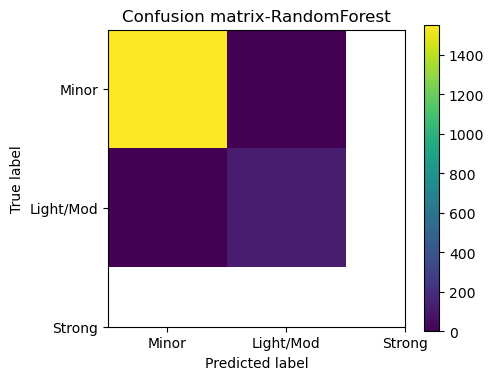

In [29]:
plt.figure(figsize=(5,4))
plt.imshow(best_cm,interpolation='nearest')
plt.title(f'Confusion matrix-{best_name}')
plt.xlabel('Predicted label'); plt.ylabel('True label')
plt.colorbar()
plt.xticks([0,1,2],['Minor','Light/Mod','Strong'])
plt.yticks([0,1,2],['Minor','Light/Mod','Strong'])
plt.tight_layout()
plt.show()


In [30]:
print("\n---Final Summary---")
print("Top regression Model by R2:", reg_ds.iloc[0]['model']if not reg_ds.empty else "None")
print("Top classification Model by accuracy:",class_ds.iloc[0]['model'] if not class_ds.empty else "None")


---Final Summary---
Top regression Model by R2: ExtraTrees
Top classification Model by accuracy: RandomForest


In [32]:
if not reg_ds.empty:
    print("\nRegression results:")
    print(reg_ds.to_string(index=False))

if not class_ds.empty:
    print("\nClassification result:")
    print(class_ds.to_string(index=False))


Regression results:
           model      mse     rmse      mae       r2
      ExtraTrees 0.001588 0.039852 0.010476 0.998798
GradientBoosting 0.002519 0.050192 0.013450 0.998093
    RandomForest 0.003458 0.058807 0.010529 0.997383
          TF_DNN 0.004183 0.064677 0.040086 0.996834
    MLPRegressor 0.006311 0.079442 0.049079 0.995223
             SVR 0.019922 0.141146 0.102142 0.984922
LinearRegression 0.125918 0.354849 0.282386 0.904698
           Ridge 0.126064 0.355055 0.282516 0.904587
      KNeighbors 0.197954 0.444920 0.349713 0.850177
           Lasso 1.231442 1.109703 0.801593 0.067972

Classification result:
             model  accuracy
      RandomForest  0.999404
  GradientBoosting  0.998809
LogisticRegression  0.997022
        ExtraTrees  0.996426
     MLPClassifier  0.996426
               KNN  0.995831
               SVC  0.995831
